In [2]:
# Import packages
%load_ext autoreload
%autoreload 2

In [3]:
import os, sys
import copy
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, SEG_CMAP, display_scarlet_results_tigress
from kuaizi.detection import Data

import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, Row, vstack, hstack


Bad key savefig.frameon in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 421 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.level in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle, line 472 ('verbose.level  : silent      # one of silent, helpful, debug, debug-annoying')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key verbose.fileo in file /projects/HSC/LSST/stack_20200903/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.set_matplotlib(dpi=100, fontsize=15)

In [5]:
TIGRESS = '/tigress/jiaxuanl/Data/HSC/LSBG'

### Johnny's completeness map for detection

In [8]:
x = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness-x.txt')
y = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness-y.txt')
comp_map = np.loadtxt(f'{TIGRESS}/Catalog/Greco_completeness_S18A/completeness.txt') / 100

In [537]:
from scipy.interpolate import interp2d

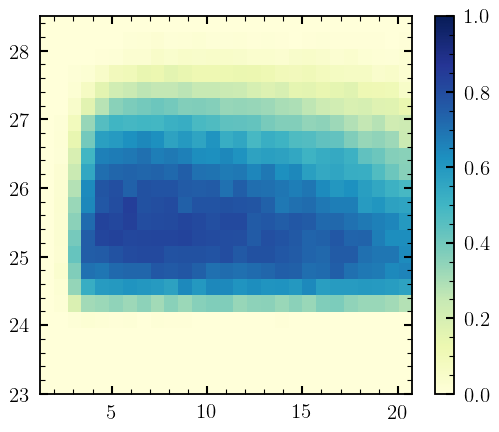

In [540]:
plt.imshow(comp_map, 
           extent=[min(x), max(x), min(y), max(y)], 
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.colorbar()

### Analyze mock gals

In [13]:
obj_cat = Table.read('./Catalog/mock_sample/mock_obj_cat_0_2000.fits')[:200]
# old_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_meas_vanillanosegmap.fits')
# old_seg_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_meas_vanillasegmap.fits')

files = [
    f'./Catalog/mock_sample/_lsbg_meas_wavelet_monotonic_wavelet_{start}_{start+200}_nosegmap.fits' 
    for start in [0]] # , 1000, 1500
meas_cat = vstack([Table.read(file) for file in files])

files = [
    f'./Catalog/mock_sample/_lsbg_meas_wavelet_monotonic_wavelet_{start}_{start+200}_segmap.fits' 
    for start in [0]] # , 1000, 1500
seg_meas_cat = vstack([Table.read(file) for file in files])

params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')[:200]

# old_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_mea_wavelet_nosegmap.fits')
# old_seg_meas_cat = Table.read('./Catalog/mock_sample/_lsbg_mea_wavelet_segmap.fits')
# params_cat = Table.read('./Catalog/mock_sample/mock_gal_param_truth.fits')

bad_flag = (~obj_cat['image_flag'].data).any(axis=1)
bad_flag |= np.isnan(meas_cat['rhalf_circularized'])

obj_cat = obj_cat[~bad_flag]
params_cat = params_cat[~bad_flag]
meas_cat = meas_cat[~bad_flag]
seg_meas_cat = seg_meas_cat[~bad_flag]

# old_meas_cat = old_meas_cat[~bad_flag]
# old_seg_meas_cat = old_seg_meas_cat[~bad_flag]

In [10]:
udg_cat = Table.read(f'{TIGRESS}/Catalog/nsa_z002_004/UDG_NSA_MW_z002_004_new.fits')

### Plot model param distribution

In [11]:
from scipy.stats import binned_statistic_2d

In [12]:
bin_num = [10, 10]
_range = [[1, 10], [24, 29]]

In [13]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range, 
    expand_binnumbers=False)

In [14]:
res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=[bin_num, bin_num],
    range=_range, 
    expand_binnumbers=False)

ValueError: The smallest edge difference is numerically 0.

In [82]:
ratio_set = []
for i in range((bin_num + 2)**2):
    ratio_set.append(np.sum(np.in1d(
        params_cat[res_truth.binnumber == i]['viz-id'].data, 
        params_cat[res_meas.binnumber == i]['viz-id'].data)) / len(
        params_cat[res_truth.binnumber == i]['viz-id'].data))

TypeError: can only concatenate list (not "int") to list

In [313]:
ratio_set = np.array(ratio_set).reshape(bin_num + 2, bin_num + 2).T
ratio_set = ratio_set[1:-1, 1:-1]

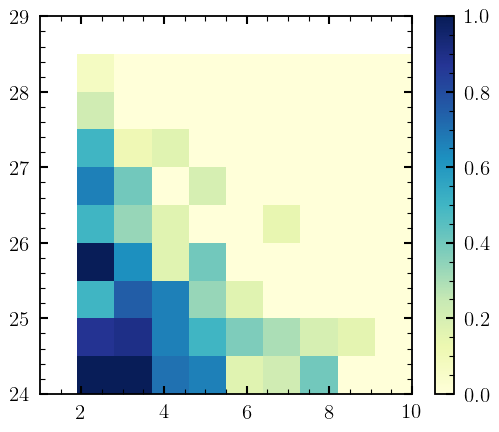

In [315]:
plt.imshow(ratio_set, 
           extent=[item for sublist in _range for item in sublist],
           vmin=0, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

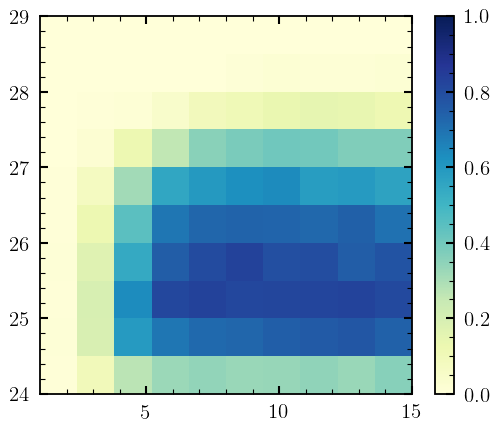

In [316]:
plt.imshow(f((res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
             (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2) / 100, 
           extent=[1, 15, 24, 29],
           vmin=0, vmax=1, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

In [317]:
mat = f((res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
             (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2) / 100
mat *= ratio_set

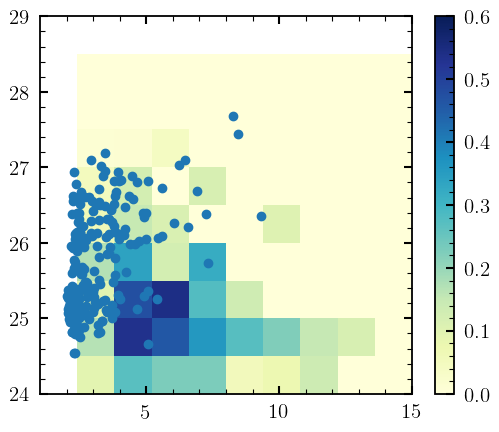

In [320]:
plt.imshow(mat,
           extent=[1, 15, 24, 29],
           vmin=0, vmax=0.6, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

plt.scatter(udg_cat['rhalf_circularized'].data * 0.168, 
            udg_cat['SB_eff_avg'][:, 0].data)

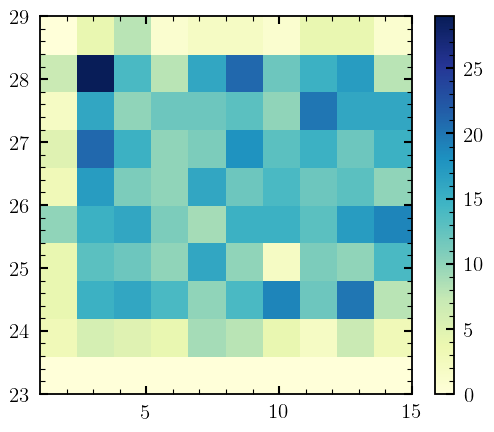

In [123]:
(h_truth, x_edges, y_edges, _) = plt.hist2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    bins=[10, 10],
    range=[[1, 15], [23, 29]],
    vmin=0,
    cmap='YlGnBu',
    )
plt.colorbar()

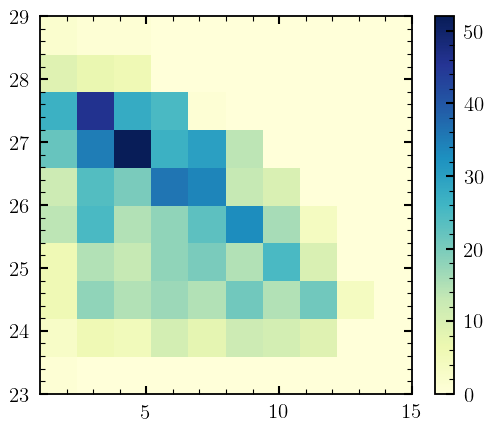

In [124]:
(h_meas, x_edges, y_edges, _) = plt.hist2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    bins=[10, 10],
    range=[[1, 15], [23, 29]],
    vmin=0,
    cmap='YlGnBu',
    )
plt.colorbar()

In [125]:
ratio = h_meas / h_truth
ratio = np.nan_to_num(ratio, 0, posinf=0)

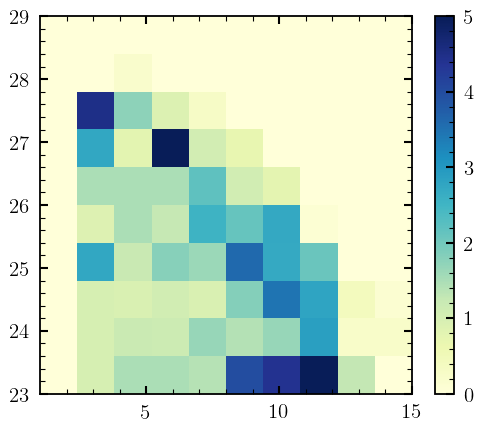

In [127]:
plt.imshow(ratio, 
           extent=[1, 15, 23, 29],
           vmin=0, vmax=5, aspect='auto', 
    cmap='YlGnBu',)
plt.colorbar()

Text(0, 0.5, '$R_e$ [measure]')

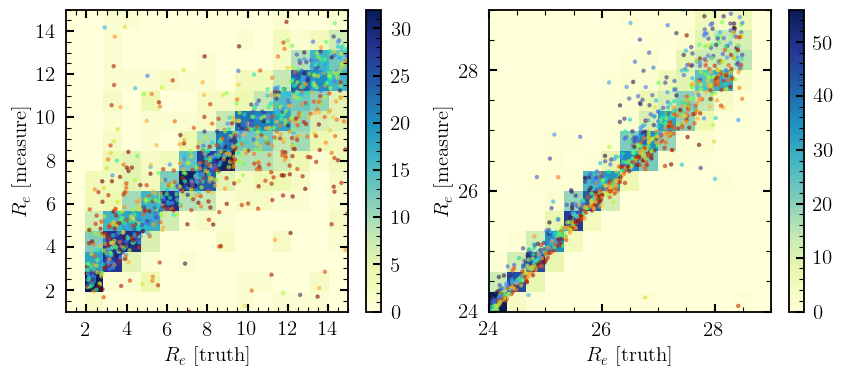

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

plt.sca(axes[0])
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
#* np.sqrt(1 - meas_cat['ell_sym'].data)
re_truth =  params_cat['rhalf_circularized'].data# * np.sqrt(1 - params_cat['ellip'].data)
# params_cat['rhalf_circularized'].data
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data


(h_re, x_edges, y_edges, im) = plt.hist2d(
    re_truth, re_meas,
    bins=[15, 15],
    range=[[1, 15], [1, 15]],
    cmap='YlGnBu',
    )
plt.scatter(re_truth, re_meas, c=SB_truth, s=5, alpha=0.5)
# plt.axes().set_aspect('equal')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar(im)
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')


plt.sca(axes[1])
(h_re, x_edges, y_edges, im) = plt.hist2d(
    SB_truth, SB_meas,
    bins=[15, 15],
    range=[[24, 29], [24, 29]],
    cmap='YlGnBu',
    )
plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
# plt.axes().set_aspect('equal')
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.colorbar(im)
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')

(24.0, 29.0)

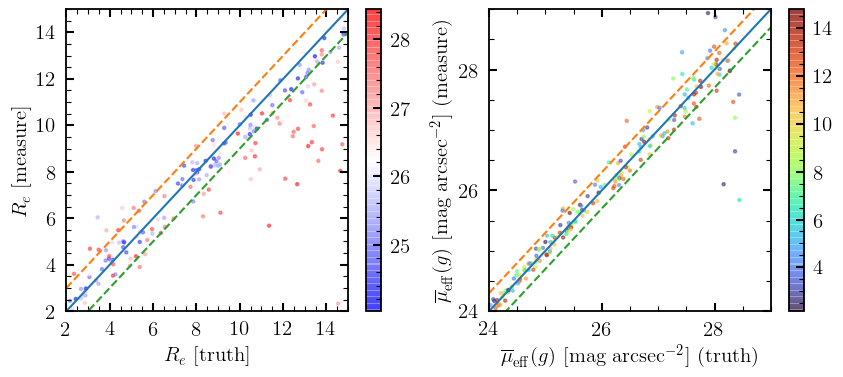

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

re_meas = meas_cat['rhalf_circularized'].data * 0.168 
#* np.sqrt(1 - meas_cat['ell_sym'].data)
re_truth =  params_cat['rhalf_circularized'].data
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.sca(axes[0])
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='bwr',
            s=5, alpha=0.5)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')

plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

plt.sca(axes[1])
SB_meas = meas_cat['SB_eff_avg'].data[:, 0]
SB_truth = params_cat['SB_eff_g'].data

plt.scatter(SB_truth, SB_meas, c=re_truth, s=5, alpha=0.5)
x = np.linspace(24, 29, 10)
plt.plot(x, x)
plt.plot(x, x + 0.3, '--')
plt.plot(x, x - 0.3, '--')
plt.colorbar()
plt.xticks(ticks=np.arange(24, 29, 2))
plt.yticks(ticks=np.arange(24, 29, 2))
plt.xlabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (truth)')
plt.ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$] (measure)')

plt.xlim(24, 29)
plt.ylim(24, 29)

(-1.0, 1.0)

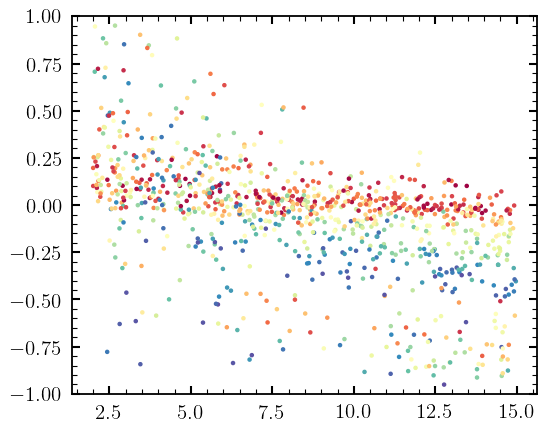

In [260]:
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
plt.scatter(re_truth, (re_meas - re_truth) / re_truth, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)

plt.ylim(-1, 1)

(2.0, 15.0)

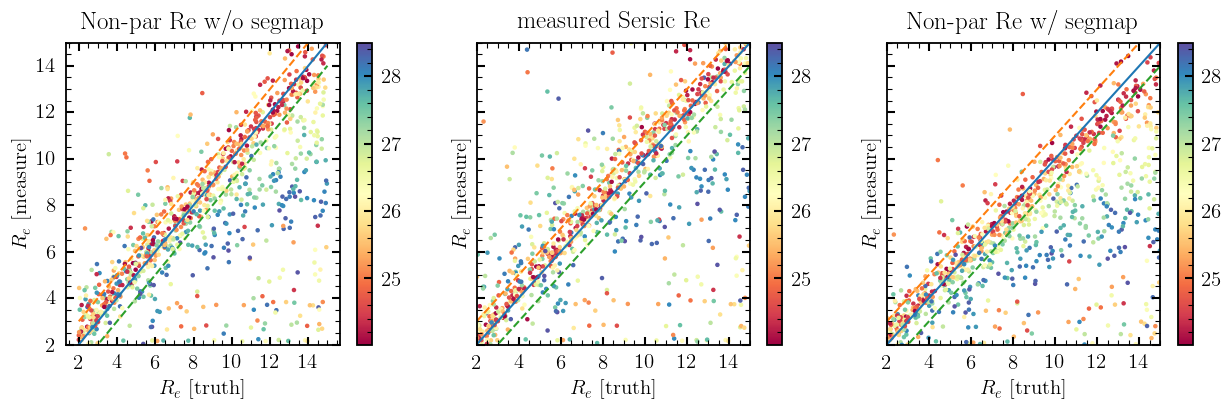

In [261]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

re_truth = params_cat['rhalf_circularized'].data
SB_truth = params_cat['SB_eff_g'].data

plt.sca(axes[0])
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('Non-par Re w/o segmap')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
# plt.xlim(2, 15)
# plt.ylim(2, 15)

plt.sca(axes[1])
re_meas = meas_cat['sersic_rhalf'].data * 0.168 * np.sqrt(1 - seg_meas_cat['ell_sym'].data)
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('measured Sersic Re')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

plt.sca(axes[2])
re_meas = seg_meas_cat['rhalf_circularized'].data * 0.168 
plt.scatter(re_truth, re_meas, c=SB_truth, 
            cmap='Spectral',
            s=5, alpha=1)
x = np.linspace(2, 15, 10)
plt.plot(x, x)
plt.plot(x, x + 1, '--')
plt.plot(x, x - 1, '--')
plt.title('Non-par Re w/ segmap')
plt.xticks(ticks=np.arange(2, 15, 2))
plt.yticks(ticks=np.arange(2, 15, 2))
plt.colorbar()
plt.xlabel(r'$R_e$ [truth]')
plt.ylabel(r'$R_e$ [measure]')
plt.xlim(2, 15)
plt.ylim(2, 15)

In [263]:
re_meas = meas_cat['rhalf_circularized'].data * 0.168 
re_truth = params_cat['rhalf_circularized'].data

In [75]:
ind = 12
re_meas[meas_cat['ID'] == ind], re_truth[meas_cat['ID'] == ind]

(array([13.00147788]), array([6.60513883]))

In [76]:
params_cat[meas_cat['ID'] == ind]

viz-id,SB_eff_g,mag_g,ellip,sersic_n,g-i,g-r,rhalf_circularized
int64,float64,float64,float64,float64,float64,float64,float64
12,27.075583208274615,20.980723785407683,0.4993303279506825,1.155423302925679,0.37714495442718127,0.2602952773656345,6.605138832076752


In [264]:
meas_cat[(re_meas - re_truth) < -3][['ID', 'SB_eff_avg', 'rhalf_circularized']]

ID,SB_eff_avg [4],rhalf_circularized
int64,float64,float64
7,27.66353988647461 .. 27.087724685668945,42.46787634843897
19,24.60338020324707 .. 23.837438583374023,21.999585776929653
20,26.01244354248047 .. 25.338911056518555,15.680631846344903
33,27.81487274169922 .. 26.471277236938477,44.968961654732716
45,26.412654876708984 .. 25.437427520751953,28.89437553635852
53,27.511062622070312 .. 27.011009216308594,48.878634603462196
57,24.182470321655273 .. 23.763343811035156,16.554068165994437
65,25.48094367980957 .. 25.064851760864258,10.440634275100589
69,25.2687931060791 .. 23.51490020751953,6.112887326615641


In [19]:
g_mag = meas_cat['mag'].data[:, 0]
r_mag = meas_cat['mag'].data[:, 1]
i_mag = meas_cat['mag'].data[:, 2]

color_bound = [0.1, 1.2]
half_width = 0.25

mask = (g_mag - i_mag < color_bound[1]) & (g_mag - i_mag > color_bound[0]) & (
    (g_mag - r_mag) > 0.7 * (g_mag - i_mag) - half_width) & (
    (g_mag - r_mag) < 0.7 * (g_mag - i_mag) + half_width) & (i_mag < 22.5)

mask &= (meas_cat['rhalf_circularized'] > 2.0 / 0.168)# & (meas_cat['rhalf_circularized'] < 12 / 0.168)

mask &= (meas_cat['SB_0'][:, 0] > 22.0)

mask &= (meas_cat['SB_eff_avg'][:, 0] > 23.0)

mask &= (meas_cat['ell_sym'] < 0.65)

# mask &= (meas_cat['M20'] < -1.1)
# mask &= (meas_cat['Gini'] < 0.7)
# mask &= ~((meas_cat['M20'] < -1.6) & (
#     meas_cat['Gini'] > meas_cat['M20'] * 0.136 + 0.788) & (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.33))
#mask &= (meas_cat['Gini'] < meas_cat['M20'] * -0.136 + 0.37)

mask &= (meas_cat['C'] < 3.5) & (meas_cat['C'] > 1.8)

# mask &= (seg_meas_cat['rhalf_circularized'] > 1.8 / 0.168) & (seg_meas_cat['rhalf_circularized'] < 12 / 0.168)

In [20]:
bin_num = [15, 15]
_range = [[1, 12], [24, 29]]
_extent = [item for sublist in _range for item in sublist]

In [21]:
res_truth = binned_statistic_2d(
    params_cat['rhalf_circularized'].data,
    params_cat['SB_eff_g'].data,
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_truth_cuts = binned_statistic_2d(
    params_cat['rhalf_circularized'].data[mask],
    params_cat['SB_eff_g'].data[mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

res_meas_cuts = binned_statistic_2d(
    meas_cat['rhalf_circularized'].data[mask] * 0.168,
    meas_cat['SB_eff_avg'].data[:, 0][mask],
    None,
    statistic='count',
    bins=bin_num,
    range=_range,
    )

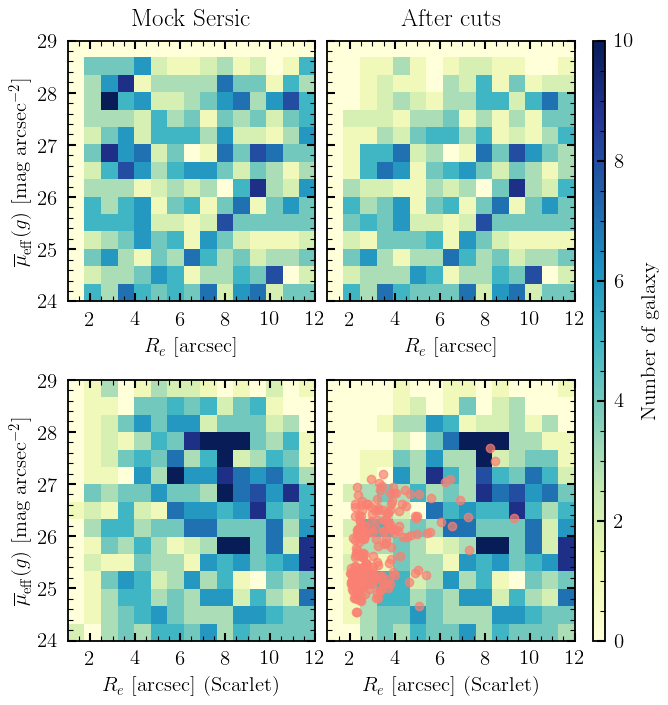

In [23]:
fig, axes = plt.subplots(2, 2, figsize=(6, 6), sharey=True, sharex=False)

# In original size
plt.sca(axes[0, 0])
plt.imshow(res_truth.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

plt.sca(axes[0, 1])
plt.imshow(res_truth_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

# In measured size
plt.sca(axes[1, 0])
plt.imshow(res_meas.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)

plt.sca(axes[1, 1])
im = plt.imshow(res_meas_cuts.statistic.T,
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=10)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))
    ax.set_xlabel(r'$R_e$ [arcsec]')
for ax in axes[1]:
    ax.set_xlabel(r'$R_e$ [arcsec] (Scarlet)')
for ax in axes[:, 0]:
    ax.set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')

axes[0, 0].set_title('Mock Sersic')
axes[0, 1].set_title('After cuts')


# # CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Number of galaxy')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

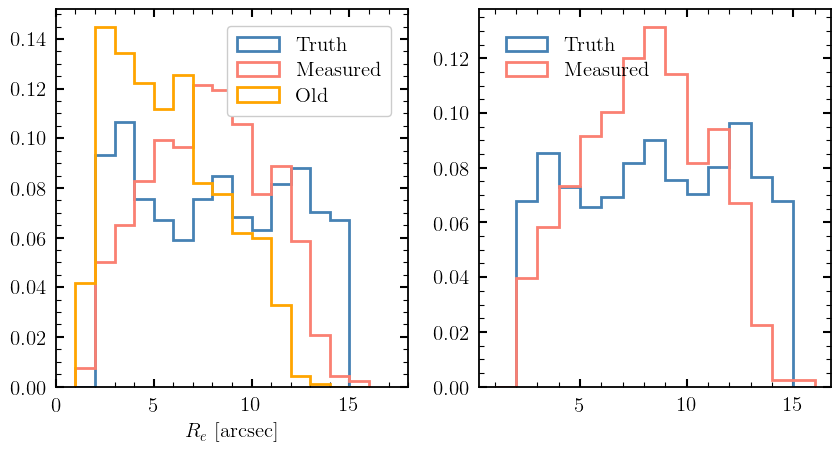

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

plt.sca(axes[0])
plt.hist(params_cat['rhalf_circularized'].data,
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='steelblue', 
         label='Truth', density=True)
plt.hist(meas_cat['rhalf_circularized'].data * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='salmon', 
         label='Measured',density=True)
plt.hist(old_meas_cat['rhalf_circularized'].data * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='orange', 
         label='Old',density=True)
plt.legend(frameon=True)
plt.xlabel(r'$R_e$ [arcsec]')
plt.xlim(0, 18)

plt.sca(axes[1])
plt.hist(params_cat['rhalf_circularized'].data[mask],
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='steelblue', 
         label='Truth', density=True)
plt.hist(meas_cat['rhalf_circularized'].data[mask] * 0.168, 
         range=[1, 16], bins=15,
         histtype='step', lw=2, color='salmon', 
         label='Measured',density=True)
plt.legend(loc='upper left')

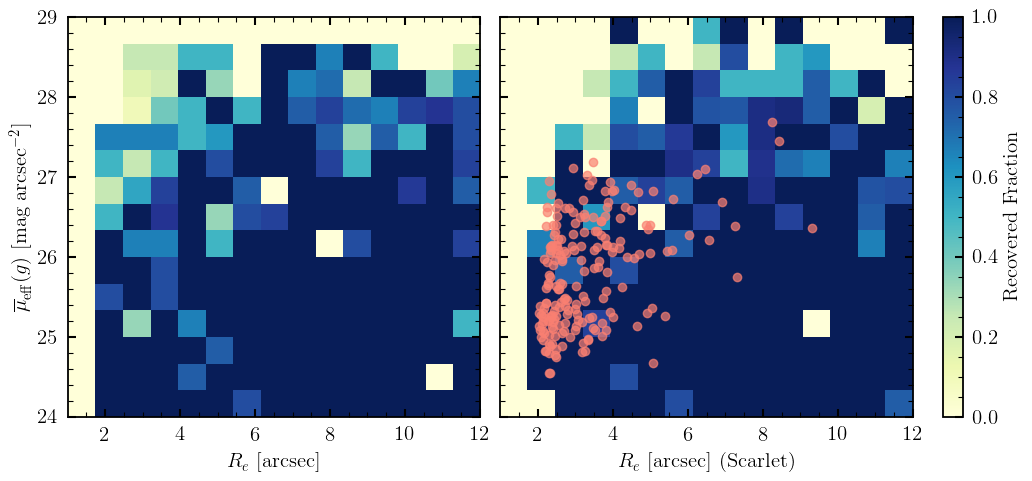

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
im = plt.imshow(np.nan_to_num(res_truth_cuts.statistic.T / res_truth.statistic.T, 0, posinf=0),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)

plt.sca(axes[1])
im = plt.imshow(np.nan_to_num(res_meas_cuts.statistic.T / res_meas.statistic.T, 0, posinf=0),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)


for ax in axes.ravel().tolist():
    ax.set_xlim(_range[0])
    ax.set_ylim(_range[1])
    ax.set_xticks(np.arange(2, 13, 2))

axes[0].set_xlabel(r'$R_e$ [arcsec]')
axes[0].set_ylabel(r'$\overline{\mu}_{\rm eff} (g)$ [mag arcsec$^{-2}$]')
axes[1].set_xlabel(r'$R_e$ [arcsec] (Scarlet)')

## CBAR
fig.subplots_adjust(right=0.97, bottom=0, top=1)
cbar_ax = fig.add_axes([1.0, 0., 0.02, 1])
fig.colorbar(im, cax=cbar_ax, label='Recovered Fraction')

plt.subplots_adjust(wspace=0.05, hspace=0.3)

In [26]:
im = plt.imshow(
    np.nan_to_num(res_meas_cuts.statistic.T / res_meas.statistic.T, 
                  0, posinf=0) * f(
        (res_truth.x_edge[1:] + res_truth.x_edge[:-1]) / 2, 
        (res_truth.y_edge[1:] + res_truth.y_edge[:-1]) / 2),
           extent=_extent,
           aspect='auto', cmap='YlGnBu', vmin=0, vmax=1)
plt.scatter(udg_cat['rhalf_circularized'].data * 0.168,
            udg_cat['SB_eff_avg'][:, 0].data, color='salmon', alpha=0.7)

plt.colorbar(im)

NameError: name 'f' is not defined

In [30]:
re_meas_ser = (meas_cat['sersic_rhalf'] * np.sqrt(1 - seg_meas_cat['ell_sym']) * 0.168)

In [34]:
obj_cat[re_meas_ser > 20]

viz-id,ra,dec,mag_auto_i,sersic_n,sersic_ell,sersic_PA,sersic_rhalf_circ,sersic_sed [4],mags [4],prefix,image_flag [4],psf_flag [4]
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bytes65,bool,bool
30,136.6152375133216,3.599789142069737,20.47277505415622,1.1818914210957483,0.03461563792924227,2.6594389809329613,8.146097730876317,0.4413263120850111 .. 1.1698381729190594,21.36087550149862 .. 20.30246058241712,./Cutout/mock_sample/mock_30,True .. True,True .. True
37,354.9021760893858,-0.4412183746230317,22.750765431992395,0.9873503595722194,0.39365534991911966,-32.70158508807893,3.7226832239839913,0.5962610959243975 .. 1.0584396405562382,23.312174247033816 .. 22.689100190418383,./Cutout/mock_sample/mock_37,True .. True,True .. True
132,350.8793484609612,0.7003492654709937,19.436209373662123,0.8017884292003261,0.17076272380551905,56.69888363117144,13.105586005812011,0.46833766537938176 .. 1.155593889142511,20.259811656931525 .. 19.279196282161944,./Cutout/mock_sample/mock_132,True .. True,True .. True
142,147.31631972743108,-0.02955614527762296,23.719885684286112,0.822445426184701,0.30291604895577184,-6.987636434520155,2.7951236582921575,0.6605437972194633 .. 1.003048141303396,24.170131637509165 .. 23.71658124056687,./Cutout/mock_sample/mock_142,True .. True,True .. True
148,336.6348721227499,1.1509880392524925,21.112340746428295,1.0945844887139127,0.1919302038005415,-89.04940755620717,3.361287332586018,0.5031336374573337 .. 1.073487734031143,21.85813236280504 .. 21.035348030350033,./Cutout/mock_sample/mock_148,True .. True,True .. True
155,334.2832677667005,0.9998169279829422,19.404115664801413,0.8753533190793384,0.5636816793364137,-8.025701921710834,11.510078648157275,0.4715441158921167 .. 1.0909329926207887,20.220309839974636 .. 19.309620474464243,./Cutout/mock_sample/mock_155,True .. True,True .. True
163,210.5663646293533,-1.3106821544400364,19.813526827698116,1.124367477914815,0.019924117132413155,-46.81259508237997,13.611351959779997,0.6158276872832716 .. 1.173054829343283,20.339878801064053 .. 19.640231048209102,./Cutout/mock_sample/mock_163,True .. True,True .. True
178,231.0977723062147,44.27895411534981,19.153963057028044,0.8035816427390805,0.370367834452326,10.609139414375818,12.718635794375833,0.45679578518409164 .. 1.029506563415559,20.004657836883084 .. 19.122390257724334,./Cutout/mock_sample/mock_178,True .. True,True .. True
201,135.7697138585649,-1.242929877038447,23.68604852921851,1.028535562678727,0.5914613826786047,-18.693846759035253,2.5034755523781707,0.7646592490414257 .. 1.1914613835918277,23.97737866430595 .. 23.495848601695617,./Cutout/mock_sample/mock_201,True .. True,True .. True


In [265]:
ind = 7

[<AxesSubplot:title={'center':'Background'}>,
 <AxesSubplot:title={'center':'Mock Image'}>,
 <AxesSubplot:title={'center':'Model'}>]

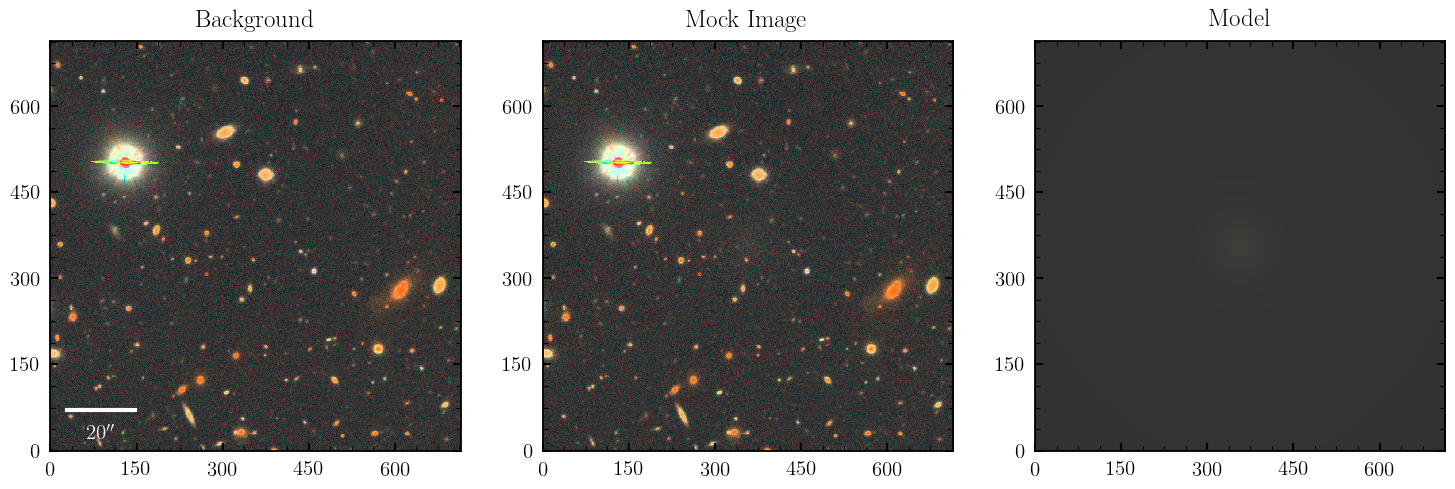

In [266]:
import pickle

with open(f'./Cutout/mock_sample/mock_{ind}.pkl', 'rb') as fp:
    gal = pickle.load(fp)
gal.display()

In [267]:
import dill
from kuaizi.measure import makeMeasurement

[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>,
 <AxesSubplot:title={'center':'log-Likelihood'}, xlabel='Iteration'>]

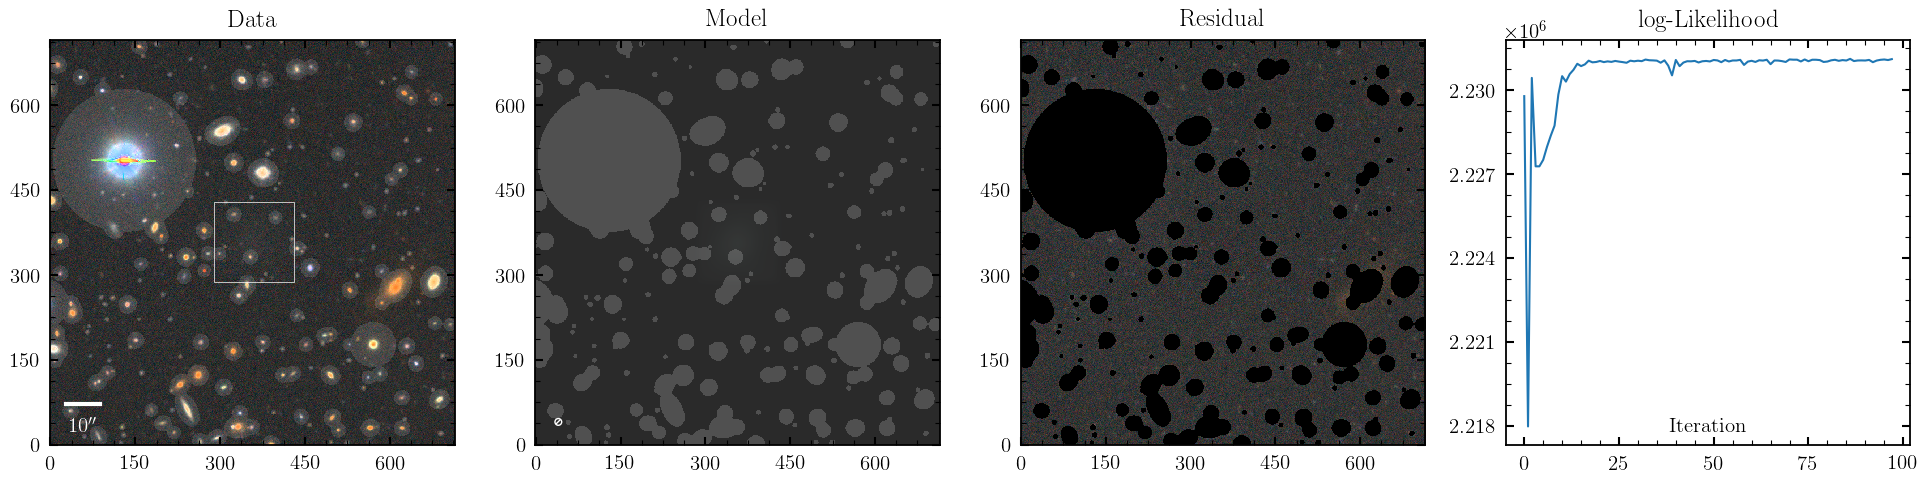

In [268]:
method = 'wavelet'
# method = 'vanilla'
with open(f'./Model/mock_sample/mock-{ind}-trained-model-{method}.df', "rb") as fp:
    blend, info, mask = dill.load(fp)
    fp.close()
    
kz.display.display_scarlet_results_tigress(
    blend,
    mask,
    show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=1,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=True)

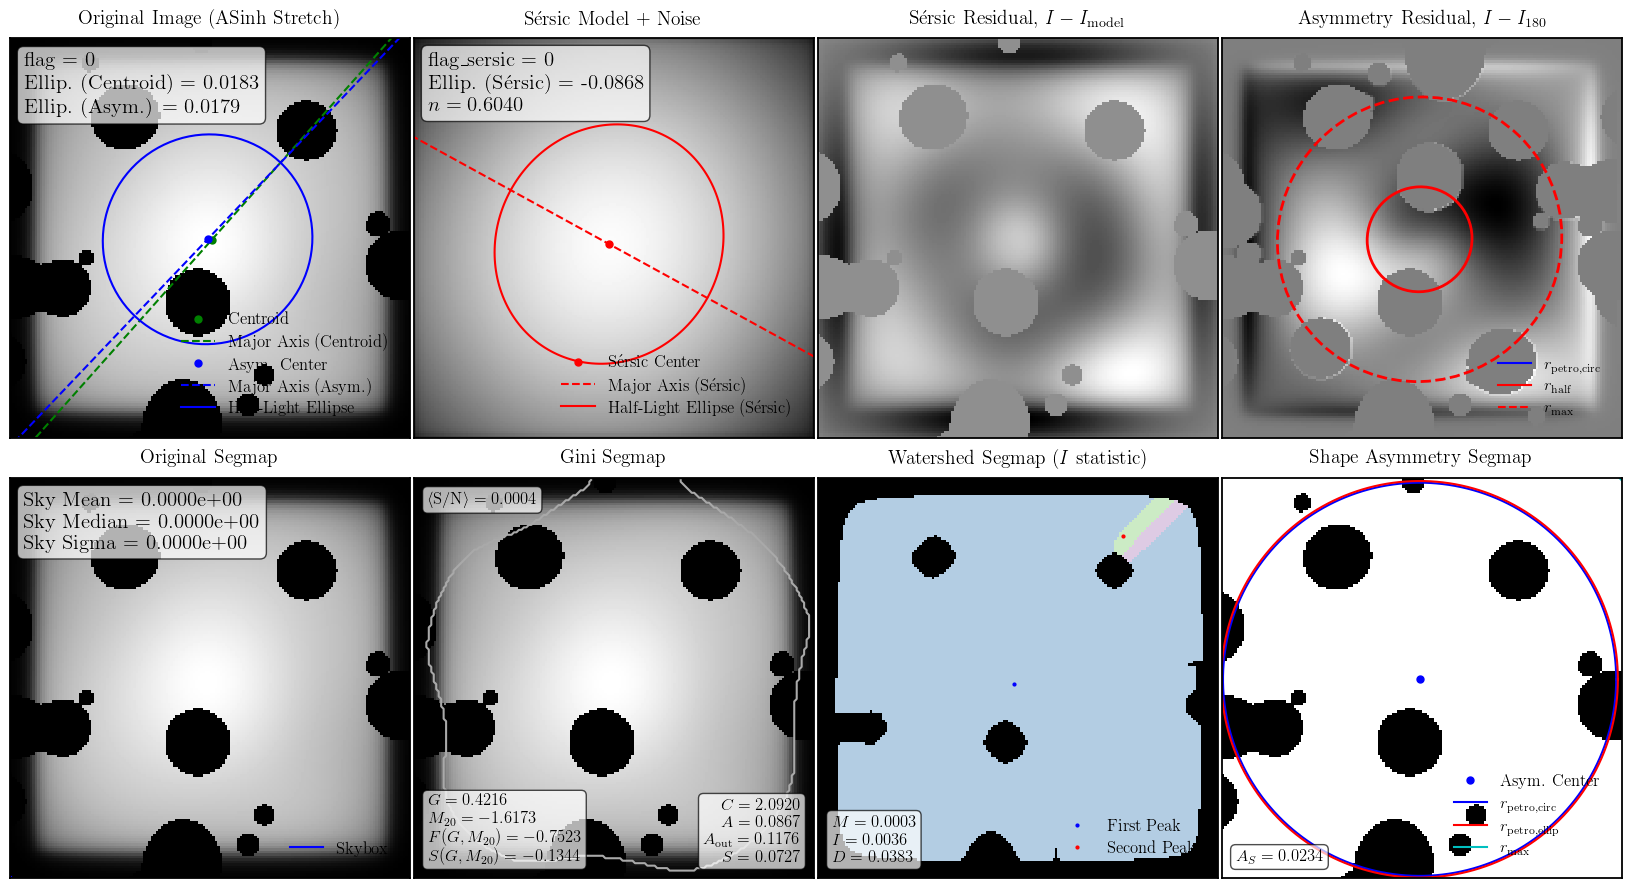

In [270]:
measurement, t = makeMeasurement(list(np.array(blend.sources)[info['sed_ind']]),
                                 blend.observations[0],
                                 #aggr_mask=mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [271]:
print(measurement['rhalf_circularized'] * 0.168, params_cat[
    params_cat['viz-id'] == ind]['rhalf_circularized'][0])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

7.134603226537748 12.097237240417355


7.561235799236977

In [272]:
gal.model.info

{'comp': [{'model': galsim.sersic.Sersic,
   'model_params': {'n': 0.9633822325633931,
    'half_light_radius': 12.097237240417355},
   'shear_params': {'q': 0.956260928877007,
    'beta': coord.Angle(-1.2817051303891247, coord.radians)},
   'sed': array([0.5723978 , 0.83970861, 1.        , 1.16199369])}],
 'imag': 19.8831568836033,
 'flux_fraction': [1.0],
 'ra': 346.1801183805011,
 'dec': 0.9159681129547782,
 'gmag': 20.4889119964195,
 'rmag': 20.072835367354816,
 'zmag': 19.720147458149533}

In [73]:
measurement['SB_eff_avg'][0], params_cat[params_cat['viz-id'] == ind]['SB_eff_g'][0]

(25.4518, 25.720428534141778)

In [179]:
with open('/home/jiaxuanl/Research/Packages/kuaizi/diezi/scarlet_modeling/mock_sample/failed_ind.txt', 'rb') as f:
    text = f.read().decode('ascii')
text = text.split(sep='\n')

In [178]:
import re

In [195]:
len([int(re.search("mock-(\d*)-trained-model-wavelet.df", tex).group(1)) for tex in text])

30

['-rw-r--r--. 1 jiaxuanl astro  45M Feb 16 02:51 mock-995-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro  59M Feb 16 02:50 mock-994-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro 132M Feb 16 02:48 mock-993-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro 157M Feb 16 02:44 mock-992-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro  71M Feb 16 02:38 mock-991-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro  37M Feb 16 02:36 mock-463-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro  60M Feb 16 02:36 mock-495-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro  87M Feb 16 02:36 mock-990-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro  96M Feb 16 02:35 mock-462-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro 109M Feb 16 02:35 mock-493-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro 116M Feb 16 02:34 mock-989-trained-model-wavelet.df',
 '-rw-r--r--. 1 jiaxuanl astro 106M Feb 16 02:33 mock-461-trained